In [130]:
import sys, yaml
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, lfilter, freqz
from scipy.optimize import minimize, Bounds
from motoman_def import *

In [145]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def dh2v(dh):
    logdh = np.log(dh)
    logv = (logdh-1.647)/-0.4619
    
    v = np.exp(logv)
    return v

def v2dh(v):
    logdh = -0.4619*np.log(v)+1.647
    
    dh = np.exp(logdh)
    return dh

def v2dh_noised(v):
    mod_noise = np.random.rand(2)-0.9
    coeff1_noised = mod_noise[0]*0.05+0.4619
    coeff2_noised = mod_noise[0]*0.5+1.647
    logdh = -coeff1_noised*np.log(v)+coeff2_noised
    
    dh = np.exp(logdh)
    return dh

def avg_by_line(job_line, flame_pos, num_segs):
    ref_idx = job_line[0]
    job_line_unique = [ref_idx]
    idx = 0
    num_points = 0
    average_pos = []
    sum = np.zeros(flame_pos.shape[1])
    while True:
        while job_line[idx] == ref_idx:
            sum = sum + flame_pos[idx,:]
            num_points += 1
            idx+=1
            if idx >= len(job_line): break
        
        average_pos.append(sum/num_points)
        sum = np.zeros(flame_pos.shape[1])
        try:
            ref_idx = job_line[idx]
            job_line_unique.append(ref_idx)
        except:
            break
        num_points = 0
    average_pos = np.array(average_pos)
    output = np.empty((num_segs, 3))
    
    # for i, line_no in enumerate(job_line_unique):
    #     output[line_no,1:] = average_pos[i,:]
    #     output[line_no,0] = line_no
    for i in range(num_segs):
         if i in job_line_unique:
              idx = job_line_unique.index(i)
              output[i,:] = average_pos[idx, :]
         else:
              output[i,:] = [None, None, None]
    #handle missing height data

    return output

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    cumsum_vec = numpy.cumsum(numpy.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return y_smooth

class speedHeightModel:
    '''
    Model relating dh to torch speed according to the equation
    ln(h) = a ln(v) + b
    '''
    def __init__(self, lam = 0.05, beta = 1, coeff_mat = [-0.4619, 1.647]):
        # Beta == 1 for non-exponentail updates
        self.coeff_mat = np.array(coeff_mat)
        self.lam = lam
        self.P = np.diag(np.ones(self.coeff_mat.shape[0])*self.lam)
        self.beta = beta
    
    def v2dh(self, v):
        logdh = self.coeff_mat[0]*np.log(v)+self.coeff_mat[1]
    
        dh = np.exp(logdh)
        return dh
    
    def dh2v(self, dh):
        logdh = np.log(dh)
        logv = (logdh-self.coeff_mat[1])/self.coeff_mat[0]
        
        v = np.exp(logv)
        return v
    
    def model_update(self, vels, dhs, weight):
        # Updates the model with new height-torchspeed data
        ln_vels = np.log(np.array(vels))
        ln_dhs = np.log(np.array(dhs))

        # check for nan values in ln(dhs)
        idxs = np.argwhere(np.isnan(ln_dhs))
        ln_dhs = np.delete(ln_dhs, idxs)
        ln_vels = np.delete(ln_vels, idxs)

        # Pseudo-inverse to calculate least squares fit based on new data
        x_mat = np.vstack((ln_vels, np.ones_like(ln_vels)))

        updated_coeff_mat = ln_dhs@np.linalg.pinv(x_mat)
        # print(updated_coeff_mat)
        # print(self.coeff_a)
        # print(self.coeff_b)
        # Model Update
        self.coeff_mat = weight*updated_coeff_mat + (1-weight)*self.coeff_mat
        # else:
        # print(self.coeff_a)
        # print(self.coeff_b)

    def model_update_RLS(self, vels, dhs):
        # Algorithm from https://osquant.com/papers/recursive-least-squares-linear-regression/
        for idx,vel in enumerate(vels):
            x  = np.array([[np.log(np.array(vel))], [1]])
            y = np.log(dhs[idx])
            if not np.isnan(y):
                r = 1+(x.T@self.P@x)/self.beta
                k = self.P@x/(r*self.beta)
                e = y-x.T@self.coeff_mat
                self.coeff_mat = self.coeff_mat+k@e
                self.P = self.P/self.beta-k@k.T*r






In [132]:
dataset='bent_tube/'
sliced_alg='slice_ER_4043/'
data_dir='../data/'+dataset+sliced_alg

config_dir='../config/'
flir_intrinsic=yaml.load(open(config_dir+'FLIR_A320.yaml'), Loader=yaml.FullLoader)
with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
por = slicing_meta['point_of_rotation']
angle = slicing_meta['layer_angle']

with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
base_thickness = slicing_meta['baselayer_thickness']

robot=robot_obj('MA2010_A0',def_path='../config/MA2010_A0_robot_default_config.yml',tool_file_path='../config/torch.csv',\
	pulse2deg_file_path='../config/MA2010_A0_pulse2deg_real.csv',d=15)
robot2=robot_obj('MA1440_A0',def_path='../config/MA1440_A0_robot_default_config.yml',tool_file_path='../config/flir.csv',\
	pulse2deg_file_path='../config/MA1440_A0_pulse2deg_real.csv',base_transformation_file='../config/MA1440_pose.csv')
positioner=positioner_obj('D500B',def_path='../config/D500B_robot_extended_config.yml',tool_file_path='../config/positioner_tcp.csv',\
	pulse2deg_file_path='../config/D500B_pulse2deg_real.csv',base_transformation_file='../config/D500B_pose.csv')

save_path = f'../../recorded_data/ER4043_bent_tube_2024_08_01_11_47_23/'
H = np.loadtxt(data_dir+'curve_pose.csv', delimiter=',')

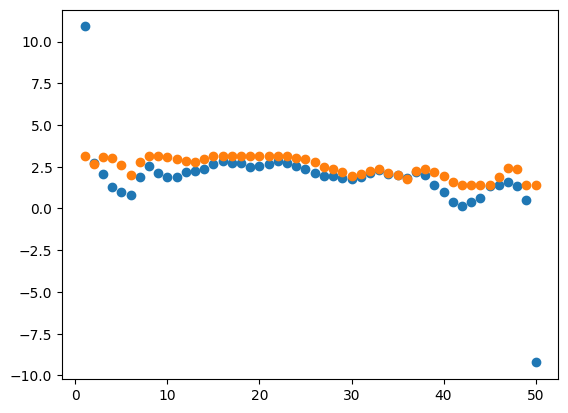

Original coeff mat:  [-0.4619  1.647 ]
new coeff mat:  [-0.829494    1.88516322]
[ 3.          4.2111427   3.03534903  3.22049271  4.50497261  7.90164046
  3.87887438  3.          3.          3.07962644  3.36465531  3.68348229
  3.8011472   3.41163193  3.          3.          3.          3.
  3.          3.          3.          3.          3.          3.16565785
  3.32859937  3.82269446  4.91961319  5.61829904  6.44794189  8.10296954
  7.19660948  6.28694055  5.62565516  7.01497483  7.82769536 10.22605674
  6.20481437  5.42407276  6.38291398  8.35565694 13.32394412 17.
 17.         17.         17.          9.16621158  5.06070358  5.50170751
 17.         17.        ]


In [133]:
layer = 50

with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
    flame_3d = pickle.load(file)
with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
    job_no = pickle.load(file)
with open(save_path+'layer_'+ str(layer-1)+'/flame_3d_'+str(layer-1)+'_0.pkl', 'rb') as file:
    flame_3d_prev = pickle.load(file)
with open(save_path+'layer_'+ str(layer-1)+'/ir_job_no_'+str(layer-1)+'.pkl', 'rb') as file:
    job_no_prev = pickle.load(file)

vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')
job_no = [i-4 for i in job_no]
job_no_prev = [i-4 for i in job_no_prev]

p = H[:3, -1]
R = H[:3, :3]

for i in range(flame_3d.shape[0]):
    flame_3d[i] = R.T@flame_3d[i]
for i in range(flame_3d_prev.shape[0]):
    flame_3d_prev[i] = R.T@flame_3d_prev[i]

layer_angle = angle*(layer-1)

layer_angle=np.deg2rad(layer_angle)
new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
flame_3d[:,0] = new_x
flame_3d[:,2] = new_z-base_thickness
new_x, new_z = rotate((por,base_thickness), (flame_3d_prev[:,0], flame_3d_prev[:,2]), layer_angle)
flame_3d_prev[:,0] = new_x
flame_3d_prev[:,2] = new_z-base_thickness
averages = avg_by_line(job_no, flame_3d, 50)
heights = averages[:,-1]
averages_prev = avg_by_line(job_no_prev, flame_3d_prev, 50)
heights_prev = averages_prev[:,-1]

# Check Direction Flags so directions match
if not np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','): 
    heights = heights[::-1]
    vel_profile = vel_profile[::-1]
if not np.loadtxt(save_path+f'layer_{layer-1}/start_dir.csv', delimiter=','): 
    heights_prev = heights_prev[::-1]

dh = heights-heights_prev
model = speedHeightModel()
dh_model = model.v2dh(vel_profile)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.linspace(1,50,50), dh)
ax.scatter(np.linspace(1,50,50), dh_model)
# ax.set_aspect('equal')
plt.show()

print("Original coeff mat: ", model.coeff_mat) 
model.model_update(vel_profile[1:-2], dh[1:-2], weight=1)
print("new coeff mat: ", model.coeff_mat) 
print(vel_profile)

C:\Users\Jack\AppData\Local\Temp\ipykernel_18772\1206153329.py:107: RuntimeWarning: invalid value encountered in log
  ln_dhs = np.log(np.array(dhs))


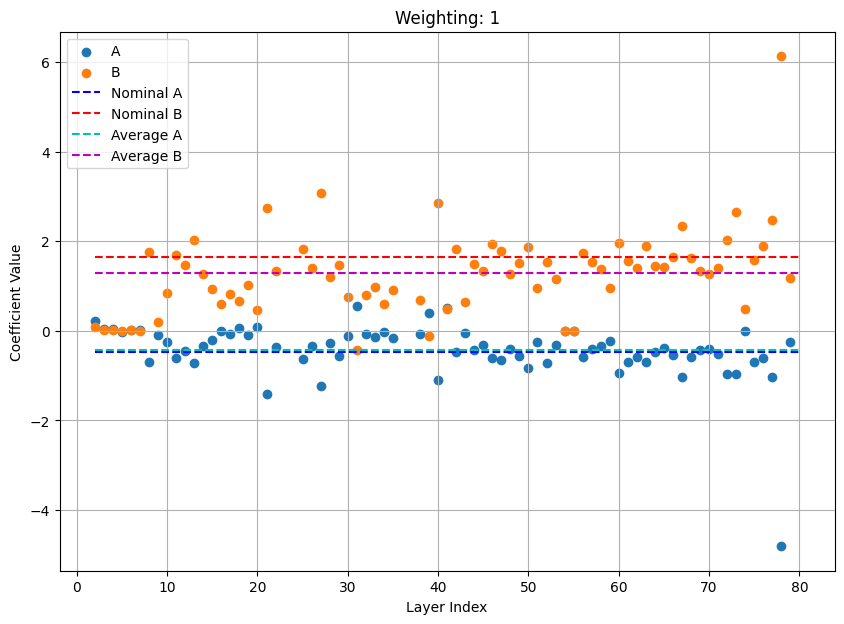

Max A:  0.5627018481319467
Min A:  -4.808978824661645
Max B:  6.135472193963679
Min B:  -0.43169184577096914


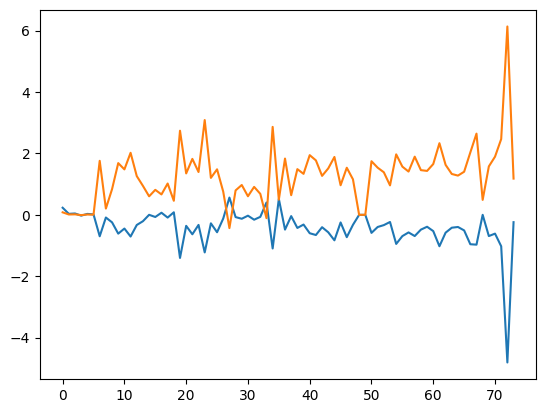

In [134]:
layer_start = 2
coeff_a = []
coeff_b = []
coeff_a_total = []
coeff_b_total = []
model = speedHeightModel()
model_each_layer = speedHeightModel()
nom_coeff_a = model.coeff_mat[0]
nom_coeff_b = model.coeff_mat[1]
for layer in range(layer_start,80):
    try:
        with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
            flame_3d = pickle.load(file)
        with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
            job_no = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/flame_3d_'+str(layer-1)+'_0.pkl', 'rb') as file:
            flame_3d_prev = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/ir_job_no_'+str(layer-1)+'.pkl', 'rb') as file:
            job_no_prev = pickle.load(file)

        vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')
        job_no = [i-4 for i in job_no]
        job_no_prev = [i-4 for i in job_no_prev]

        p = H[:3, -1]
        R = H[:3, :3]

        for i in range(flame_3d.shape[0]):
            flame_3d[i] = R.T@flame_3d[i]
        for i in range(flame_3d_prev.shape[0]):
            flame_3d_prev[i] = R.T@flame_3d_prev[i]

        layer_angle = angle*(layer-1)

        layer_angle=np.deg2rad(layer_angle)
        new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
        flame_3d[:,0] = new_x
        flame_3d[:,2] = new_z-base_thickness
        new_x, new_z = rotate((por,base_thickness), (flame_3d_prev[:,0], flame_3d_prev[:,2]), layer_angle)
        flame_3d_prev[:,0] = new_x
        flame_3d_prev[:,2] = new_z-base_thickness
        averages = avg_by_line(job_no, flame_3d, 50)
        heights = averages[:,-1]
        averages_prev = avg_by_line(job_no_prev, flame_3d_prev, 50)
        heights_prev = averages_prev[:,-1]

        # Check Direction Flags so directions match
        if not np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','): 
            heights = heights[::-1]
            vel_profile = vel_profile[::-1]
        if not np.loadtxt(save_path+f'layer_{layer-1}/start_dir.csv', delimiter=','): 
            heights_prev = heights_prev[::-1]

        dh = heights-heights_prev
        dh_model = model.v2dh(vel_profile)
        # fig, ax = plt.subplots()
        # ax.scatter(np.log(vel_profile),np.log(heights))
        # ax.set_title(f"Layer {layer}")
        # plt.show()
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.scatter(np.linspace(1,50,50), dh)
        # ax.scatter(np.linspace(1,50,50), dh_model)
        # ax.set_aspect('equal')
        # plt.show()

        # print("Original A coeff: ", model.coeff_a)
        # print("Original B coeff: ", model.coeff_b)
        
        weight = 1
        model.model_update(vel_profile[1:-2], dh[1:-2], weight=weight)
        model_each_layer.model_update(vel_profile[1:-2], dh[1:-2], weight = 1)
        # print("New A coeff: ", model.coeff_a)
        # print("New B coeff: ", model.coeff_b)
        coeff_a.append(model.coeff_mat[0])
        coeff_b.append(model.coeff_mat[1])
        coeff_a_total.append(model_each_layer.coeff_mat[0])
        coeff_b_total.append(model_each_layer.coeff_mat[1])

    except IndexError:
        coeff_a.append(None)
        coeff_b.append(None)
        pass

average_a = np.average(coeff_a_total)
average_b = np.average(coeff_b_total)

plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a)-1,len(coeff_a)), coeff_a)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b)-1,len(coeff_b)), coeff_b)
plt.plot([layer_start, layer_start+len(coeff_a)],[nom_coeff_a, nom_coeff_a], 'b--')
plt.plot([layer_start, layer_start+len(coeff_b)],[nom_coeff_b, nom_coeff_b], 'r--')
plt.plot([layer_start, layer_start+len(coeff_b)], [average_a, average_a], 'c--')
plt.plot([layer_start, layer_start+len(coeff_b)], [average_b, average_b], 'm--')
plt.legend(("A", "B", "Nominal A", "Nominal B", "Average A", "Average B"))
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.gca().grid()
plt.gcf().set_size_inches(10,7)
plt.title(f"Weighting: {weight}")
plt.show()

plt.plot(coeff_a_total)
plt.plot(coeff_b_total)
print("Max A: ", max(coeff_a_total))
print("Min A: ", min(coeff_a_total))
print("Max B: ", max(coeff_b_total))
print("Min B: ", min(coeff_b_total))

np.savetxt("model_coeffs_real.csv", np.array([coeff_a_total, coeff_b_total]).T, delimiter=',')

C:\Users\Jack\AppData\Local\Temp\ipykernel_18772\1206153329.py:131: RuntimeWarning: invalid value encountered in log
  y = np.log(dhs[idx])


too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
too many indices for array: array is 1-dimensional, but 2 were indexed
Final Coefficient Matrix:  [-0.38152718  1.30751551]
(2,)


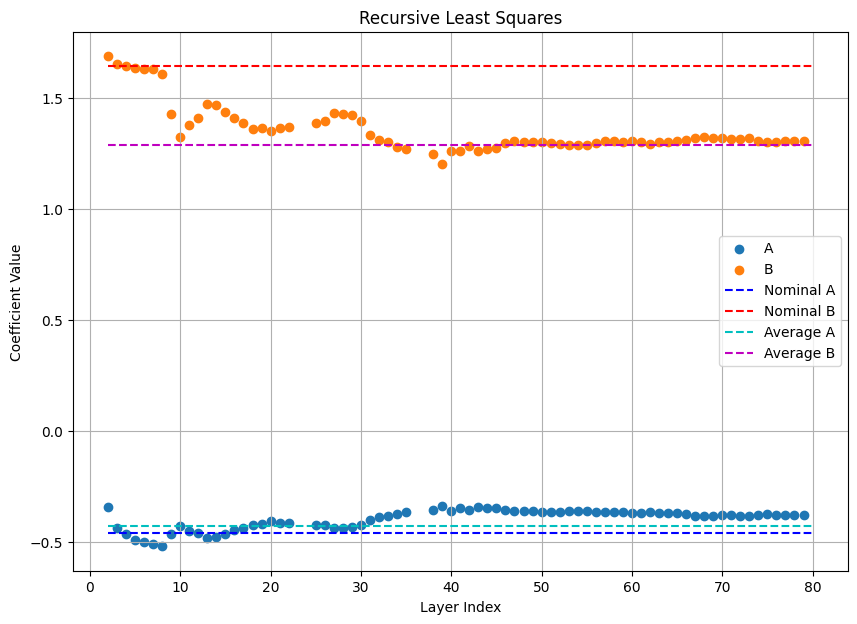

In [135]:
layer_start = 2
coeff_a = []
coeff_b = []
coeff_a_total = []
coeff_b_total = []
model = speedHeightModel()
nom_coeff_a = model.coeff_mat[0]
nom_coeff_b = model.coeff_mat[1]
for layer in range(layer_start,80):
    try:
        with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
            flame_3d = pickle.load(file)
        with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
            job_no = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/flame_3d_'+str(layer-1)+'_0.pkl', 'rb') as file:
            flame_3d_prev = pickle.load(file)
        with open(save_path+'layer_'+ str(layer-1)+'/ir_job_no_'+str(layer-1)+'.pkl', 'rb') as file:
            job_no_prev = pickle.load(file)

        vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')
        job_no = [i-4 for i in job_no]
        job_no_prev = [i-4 for i in job_no_prev]

        p = H[:3, -1]
        R = H[:3, :3]

        for i in range(flame_3d.shape[0]):
            flame_3d[i] = R.T@flame_3d[i]
        for i in range(flame_3d_prev.shape[0]):
            flame_3d_prev[i] = R.T@flame_3d_prev[i]

        layer_angle = angle*(layer-1)

        layer_angle=np.deg2rad(layer_angle)
        new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
        flame_3d[:,0] = new_x
        flame_3d[:,2] = new_z-base_thickness
        new_x, new_z = rotate((por,base_thickness), (flame_3d_prev[:,0], flame_3d_prev[:,2]), layer_angle)
        flame_3d_prev[:,0] = new_x
        flame_3d_prev[:,2] = new_z-base_thickness
        averages = avg_by_line(job_no, flame_3d, 50)
        heights = averages[:,-1]
        averages_prev = avg_by_line(job_no_prev, flame_3d_prev, 50)
        heights_prev = averages_prev[:,-1]

        # Check Direction Flags so directions match
        if not np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','): 
            heights = heights[::-1]
            vel_profile = vel_profile[::-1]
        if not np.loadtxt(save_path+f'layer_{layer-1}/start_dir.csv', delimiter=','): 
            heights_prev = heights_prev[::-1]

        dh = heights-heights_prev
        dh_model = model.v2dh(vel_profile)

        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.scatter(np.linspace(1,50,50), dh)
        # ax.scatter(np.linspace(1,50,50), dh_model)
        # ax.set_aspect('equal')
        # plt.show()

        # print("Original A coeff: ", model.coeff_a)
        # print("Original B coeff: ", model.coeff_b)
        
        model.model_update_RLS(vel_profile[1:-2], dh[1:-2])
        # print("New A coeff: ", model.coeff_a)
        # print("New B coeff: ", model.coeff_b)
        coeff_a.append(model.coeff_mat[0])
        coeff_b.append(model.coeff_mat[1])

    except IndexError as e:
        print(e)
        coeff_a.append(None)
        coeff_b.append(None)
        pass

print("Final Coefficient Matrix: ", model.coeff_mat)
print(model.coeff_mat.shape)

plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a)-1,len(coeff_a)), coeff_a)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b)-1,len(coeff_b)), coeff_b)
plt.plot([layer_start, layer_start+len(coeff_a)],[nom_coeff_a, nom_coeff_a], 'b--')
plt.plot([layer_start, layer_start+len(coeff_b)],[nom_coeff_b, nom_coeff_b], 'r--')
plt.plot([layer_start, layer_start+len(coeff_b)], [average_a, average_a], 'c--')
plt.plot([layer_start, layer_start+len(coeff_b)], [average_b, average_b], 'm--')
plt.legend(("A", "B", "Nominal A", "Nominal B", "Average A", "Average B"))
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.gca().grid()
plt.gcf().set_size_inches(10,7)
plt.title(f"Recursive Least Squares")
plt.show()


In [136]:
print("starting")
num_layers = 80
part_len = 50 #mm
v_min = 5
max_dH = v2dh(v_min)
v_max = 15
min_dH = v2dh(v_max)
points_per_layer = 100

layer_angle = np.arcsin((max_dH-min_dH)/part_len)
rot_point = max_dH/np.tan(layer_angle)-part_len/2
print(np.rad2deg(layer_angle))
print(rot_point)
print(max_dH)
print(min_dH)
print(np.rad2deg(num_layers*layer_angle))

starting
1.1257976619508032
100.6131657840027
2.468475190539253
1.4860946104132609
90.06381295606425


Final Height Error:  18.64003838445148


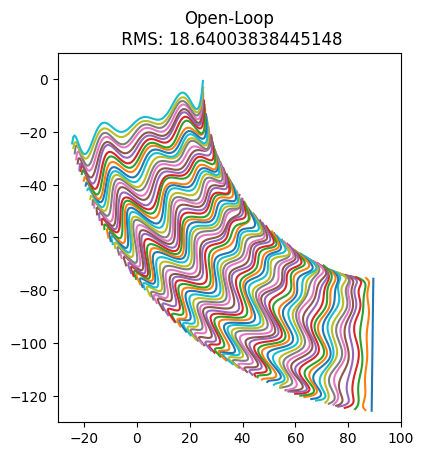

In [153]:
np.random.seed(1234)
def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)*4
    noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/20)), 10, mode='interp')
    # noise_profile = noise+nom_profile
    return noise_profile
# nominal layer plot
layers = []
x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
height_profile = np.linspace(max_dH, min_dH, points_per_layer)
vel_nom = dh2v(height_profile)

curve_curved=np.zeros((num_layers*points_per_layer,2))
new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
# first layer
curve_curved[:points_per_layer, 0] = x_vals
curve_curved[:points_per_layer, 1] = v2dh_noised(vel_nom)+10
offset = 0
for i in range(1,num_layers):
    if not(coeff_a[i-offset] == None or coeff_b[i-offset] == None):
        model = speedHeightModel(coeff_mat=[coeff_a[i], coeff_b[i]])
    else:
        model = speedHeightModel(coeff_mat=model.coeff_mat)
        offset += 1
    new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
    curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(model.v2dh(vel_nom)+curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1])
#final rotation
curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
final_error = np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                      len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]))
print("Final Height Error: ", final_error)
fig,ax = plt.subplots()
for i in range(num_layers):
    ax.plot(curve_curved[i*points_per_layer:(i+1)*points_per_layer,0], curve_curved[i*points_per_layer:(i+1)*points_per_layer,1])
ax.set_aspect('equal')
ax.set_xlim(-30,100)
ax.set_ylim(-130, 10)
ax.set_title(f"Open-Loop\n RMS: {final_error}")
plt.show()

In [138]:
def delta_v(v):
    delta_v = [v[i]-v[i+1] for i in range(len(v)-1)]
    return delta_v
def v_opt(v_next, v_prev, h_err, h_targ, lam, beta):
    return norm(h_targ+h_err-v2dh(v_next), 2)**2 + lam*norm(v_next-v_prev, 2)**2 + beta*norm(delta_v(v_next), 2)**2


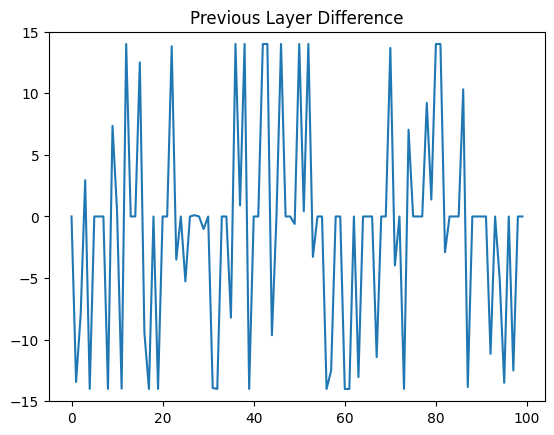

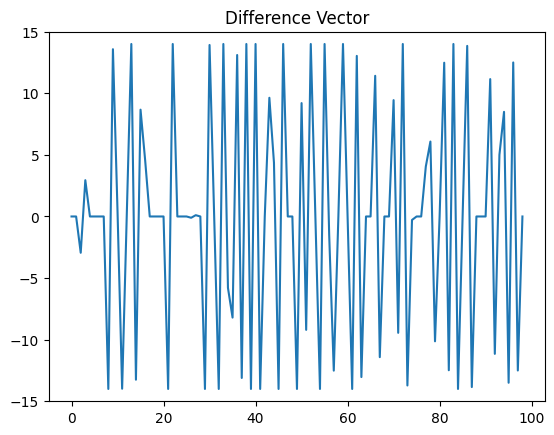

Final Height Error:  3.149115590802419


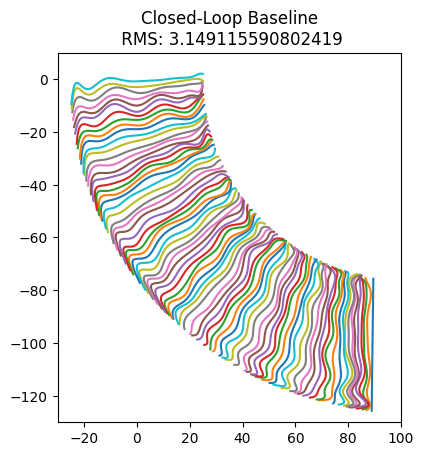

In [155]:
np.random.seed(1234)
vel_prev = vel_nom
# alpha = 1.32
# beta = 0.95
alpha = 0
beta = 0
#constraints
bounds = Bounds(3, 17)
def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)*4
    noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/2)), 10, mode='interp')
    # noise_profile = noise+nom_profile
    return noise_profile
def measurement_noise(n):
    return (np.random.rand(n)-0.5)*8
# nominal layer plot
layers = []
x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
height_profile = np.linspace(max_dH, min_dH, points_per_layer)
vel_nom = dh2v(height_profile)

curve_curved=np.zeros((num_layers*points_per_layer,2))
new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
# first layer
curve_curved[:points_per_layer, 0] = x_vals
curve_curved[:points_per_layer, 1] = v2dh_noised(vel_nom)+10
offset = 0
fig,ax = plt.subplots()
fig1,ax1 = plt.subplots()
for i in range(1,num_layers):
    if not(coeff_a[i-offset] == None or coeff_b[i-offset] == None):
        model = speedHeightModel(coeff_mat=[coeff_a[i], coeff_b[i]])
    else:
        model = speedHeightModel(coeff_mat=model.coeff_mat)
        offset += 1
    new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
    curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T
    # measure and correct
    height_vals_prev = curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]
    height_err = 0-height_vals_prev+measurement_noise(len(height_vals_prev))
    opt_result=minimize(v_opt, vel_nom, (vel_prev, height_err, height_profile, alpha, beta), bounds=bounds,
                        options = {'maxfun':100000})
    if not opt_result.success: 
        print(opt_result)
        raise ValueError(opt_result.message)
    vel_profile = opt_result.x
    if i == 20:
        ax.plot(vel_profile-vel_prev)
        ax1.plot(delta_v(vel_profile))

    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(v2dh_noised(vel_profile)+height_vals_prev)

    vel_prev = vel_profile
ax.set_title("Previous Layer Difference")
ax.set_ylim(-15, 15)
ax1.set_ylim(-15,15)
ax1.set_title("Difference Vector")
plt.show()
#final rotation
curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
final_error = np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                      len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]))
print("Final Height Error: ", final_error)
fig,ax = plt.subplots()
for i in range(num_layers):
    ax.plot(curve_curved[i*points_per_layer:(i+1)*points_per_layer,0], curve_curved[i*points_per_layer:(i+1)*points_per_layer,1])
ax.set_aspect('equal')
ax.set_aspect('equal')
ax.set_xlim(-30,100)
ax.set_ylim(-130, 10)
ax.set_title(f"Closed-Loop Baseline\n RMS: {final_error}")
plt.show()

In [157]:
alpha = 1.32
beta=0
bounds = Bounds(3, 17)
def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)*4
    noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/2)), 6, mode='nearest')
    # noise_profile = noise+nom_profile
    return noise_profile
def measurement_noise(n):
    return (np.random.rand(n)-0.5)*8

for alpha in np.linspace(1,2,10):
    for beta in np.linspace(0,1,10):
        np.random.seed(1234)
        vel_prev = vel_nom
        #constraints
        
        # nominal layer plot
        layers = []
        x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
        height_profile = np.linspace(max_dH, min_dH, points_per_layer)
        vel_nom = dh2v(height_profile)

        curve_curved=np.zeros((num_layers*points_per_layer,2))
        new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
        # first layer
        curve_curved[:points_per_layer, 0] = x_vals
        curve_curved[:points_per_layer, 1] = v2dh_noised(vel_nom)
        offset = 0
        for i in range(1,num_layers):
            if not(coeff_a[i-offset] == None or coeff_b[i-offset] == None):
                model = speedHeightModel(coeff_mat=[coeff_a[i], coeff_b[i]])
            else:
                model = speedHeightModel(coeff_mat=model.coeff_mat)
                offset += 1
            new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
            curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T
            # measure and correct
            height_vals_prev = curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]
            height_err = 0-height_vals_prev+measurement_noise(len(height_vals_prev))
            opt_result=minimize(v_opt, vel_nom, (vel_prev, height_err, height_profile, alpha, beta), bounds=bounds,
                                options = {'maxfun':100000})
            if not opt_result.success: 
                print(opt_result)
                raise ValueError(opt_result.message)
            vel_profile = opt_result.x

            curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
            curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(v2dh_noised(vel_profile)+height_vals_prev)

            vel_prev = vel_profile
        #final rotation
        curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
        final_error = np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                            len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]))
        print(f"Final Height Error at alpha={alpha}, beta={beta}: ", final_error)

        

Final Height Error at alpha=1.0, beta=0.0:  1.8620325942818354
Final Height Error at alpha=1.0, beta=0.1111111111111111:  1.69264389183848
Final Height Error at alpha=1.0, beta=0.2222222222222222:  1.6824266562464065
Final Height Error at alpha=1.0, beta=0.3333333333333333:  1.6878250950650957
Final Height Error at alpha=1.0, beta=0.4444444444444444:  1.6995608700335745
Final Height Error at alpha=1.0, beta=0.5555555555555556:  1.7161699042921417
Final Height Error at alpha=1.0, beta=0.6666666666666666:  1.731169325211579
Final Height Error at alpha=1.0, beta=0.7777777777777777:  1.745773843214495
Final Height Error at alpha=1.0, beta=0.8888888888888888:  1.758034138847287
Final Height Error at alpha=1.0, beta=1.0:  1.7689494013761164
Final Height Error at alpha=1.1111111111111112, beta=0.0:  1.786850152798462
Final Height Error at alpha=1.1111111111111112, beta=0.1111111111111111:  1.643000211346725
Final Height Error at alpha=1.1111111111111112, beta=0.2222222222222222:  1.6216020647